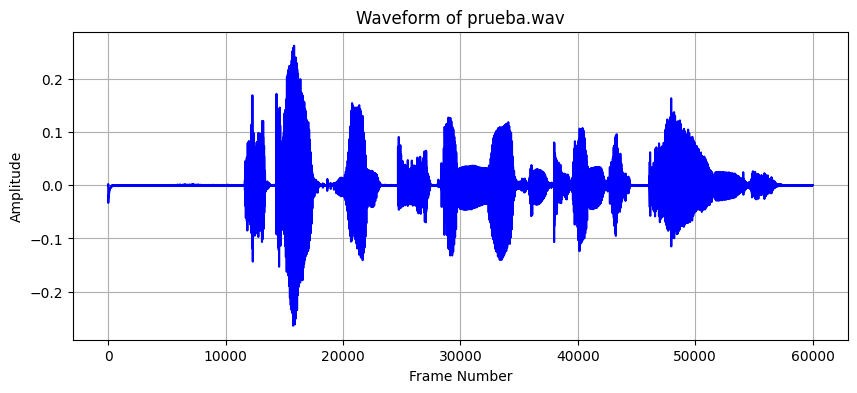

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf

filename = "../../prueba.wav"
audio_data, sample_rate = sf.read(filename)

frame_numbers = np.arange(len(audio_data))

plt.figure(figsize=(10, 4))
plt.plot(frame_numbers, audio_data, color='b')
plt.title('Waveform of prueba.wav')
plt.xlabel('Frame Number')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

600


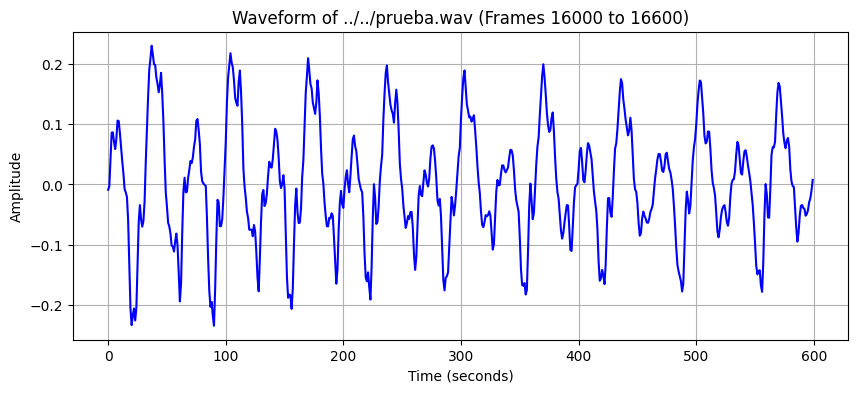

In [40]:
frame_length_ms = 30
frame_length_samples = int(frame_length_ms * sample_rate / 1000)
print(frame_length_samples)
start_frame = 16000
end_frame = start_frame + frame_length_samples

start_index = start_frame
end_index = min(end_frame, len(audio_data))

audio_data_frame = audio_data[start_index:end_index]

plt.figure(figsize=(10, 4))
plt.plot(audio_data_frame, color='b')
plt.title('Waveform of {} (Frames {} to {})'.format(filename, start_frame, end_frame))
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

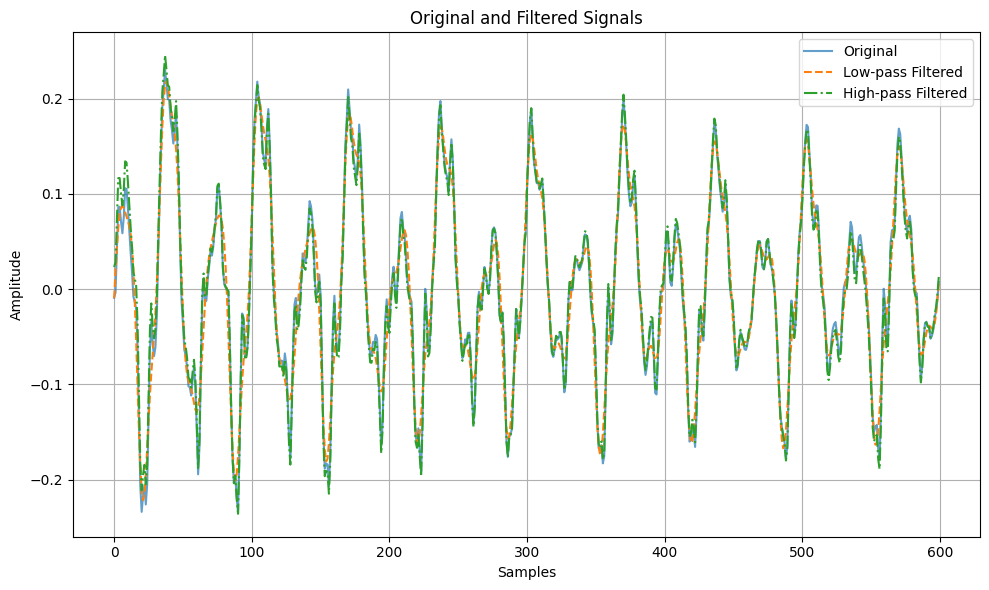

In [41]:
from scipy.signal import butter, sosfiltfilt

cutoff_low = 2000  # Low-pass cutoff frequency in Hz
cutoff_high = 50  # High-pass cutoff frequency in Hz

sos_low = butter(10, cutoff_low, 'lowpass', fs=sample_rate, output='sos')
sos_high = butter(10, cutoff_high, 'highpass', fs=sample_rate, output='sos')

filtered_low = sosfiltfilt(sos_low, audio_data_frame)
filtered_high = sosfiltfilt(sos_high, audio_data_frame)

plt.figure(figsize=(10, 6))
plt.plot(audio_data_frame, label='Original', alpha=0.7)

plt.plot(filtered_low, label='Low-pass Filtered', linestyle='--')
plt.plot(filtered_high, label='High-pass Filtered', linestyle='-.')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('Original and Filtered Signals')
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

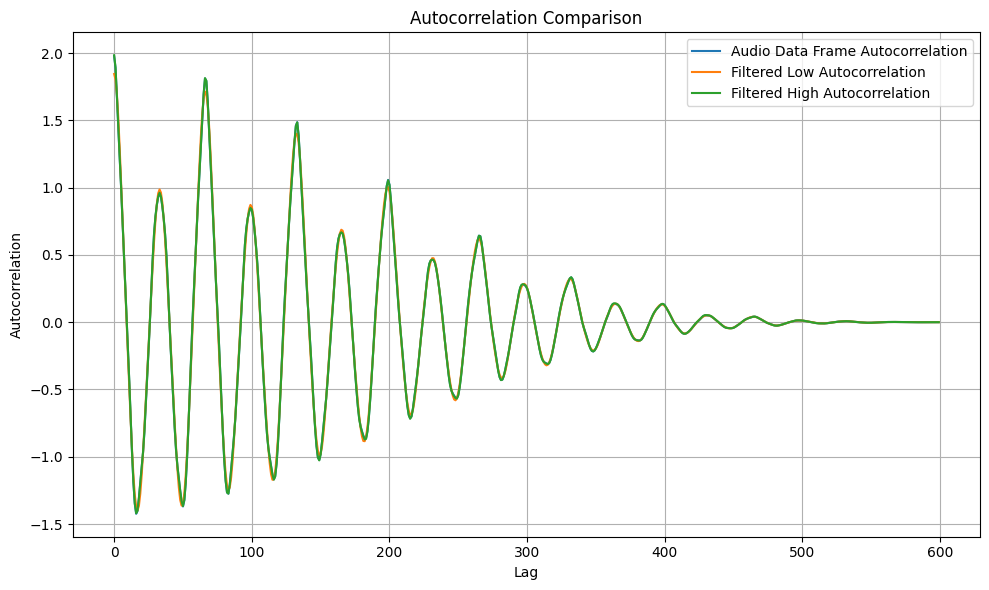

In [42]:
def autocorr(signal):
    # Compute autocorrelation
    autocorr_result = np.correlate(signal, signal, mode='full')
    return autocorr_result[len(autocorr_result) // 2:]  # Take the right half

def hamming_window(signal):
    return np.hamming(len(signal)) * signal

autocorr_audio = autocorr(hamming_window(audio_data_frame))
autocorr_filtered_low = autocorr(hamming_window(filtered_low))
autocorr_filtered_high = autocorr(hamming_window(filtered_high))

plt.figure(figsize=(10, 6))
plt.plot(autocorr_audio, label='Audio Data Frame Autocorrelation')
plt.plot(autocorr_filtered_low, label='Filtered Low Autocorrelation')
plt.plot(autocorr_filtered_high, label='Filtered High Autocorrelation')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

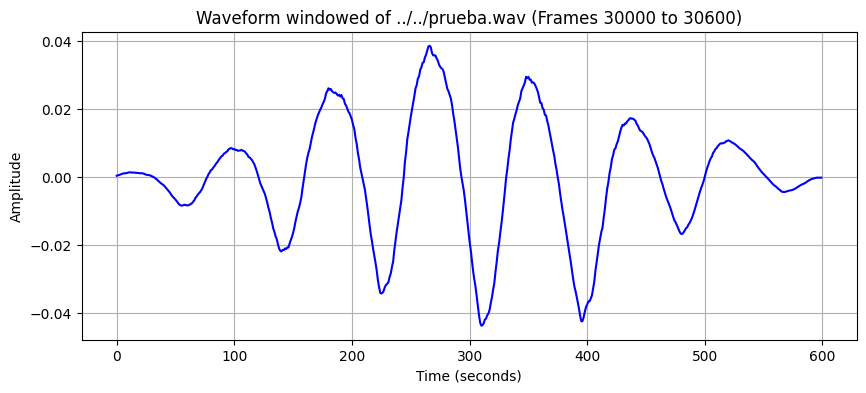

In [31]:
window_length = len(filtered_low)

hamming_window = np.hamming(window_length)

audio_data_frame_windowed = filtered_high * hamming_window

plt.figure(figsize=(10, 4))
plt.plot(audio_data_frame_windowed, color='b')
plt.title('Waveform windowed of {} (Frames {} to {})'.format(filename, start_frame, end_frame))
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

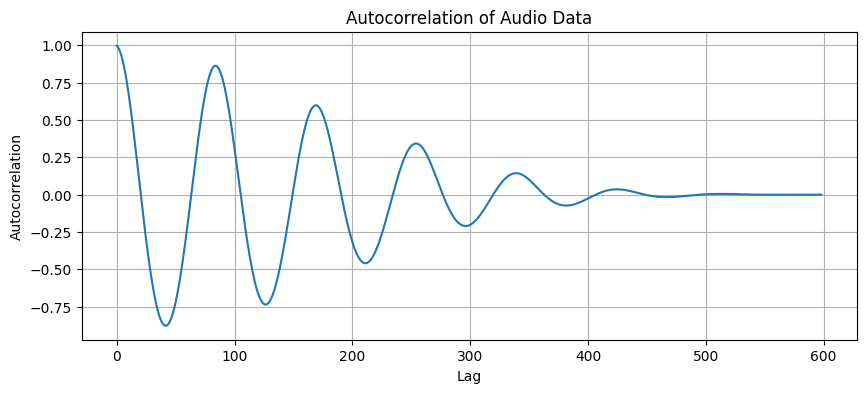

In [32]:
autocorr = np.correlate(audio_data_frame_windowed, audio_data_frame_windowed, mode='full')

autocorr /= np.max(autocorr)

autocorr = autocorr

plt.figure(figsize=(10, 4))
plt.plot(autocorr[600:1200])
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of Audio Data')
plt.grid(True)
plt.show()

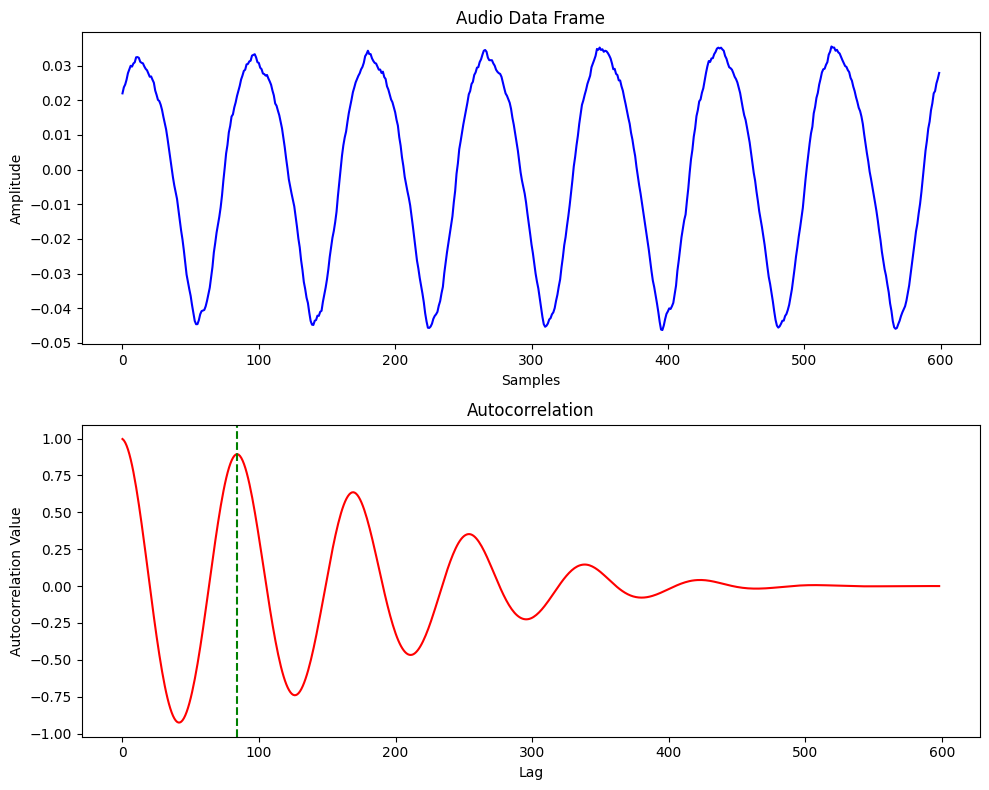

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

axs[0].plot(audio_data_frame, color='blue')
axs[0].set_title('Audio Data Frame')
axs[0].set_xlabel('Samples')
axs[0].set_ylabel('Amplitude')

axs[1].plot(autocorr[600:1200], color='red')
axs[1].set_title('Autocorrelation')
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('Autocorrelation Value')

max_index = np.argmax(autocorr[640:1200])
axs[1].axvline(x=max_index+40, color='green', linestyle='--', label='First Maximum')

plt.tight_layout()

plt.show()

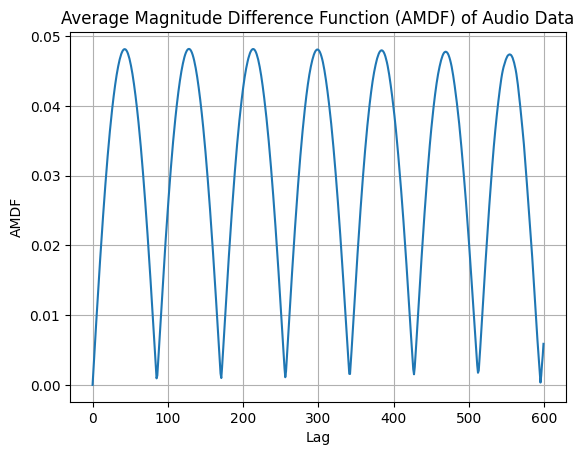

In [4]:
def compute_amdf(signal):
    N = len(signal)
    amdf = np.zeros(N)  

    for lag in range(1, N):
        amdf[lag] = np.mean(np.abs(signal[:-lag] - signal[lag:]))
        
    return amdf

amdf = compute_amdf(audio_data_frame)

plt.plot(amdf)
plt.xlabel('Lag')
plt.ylabel('AMDF')
plt.title('Average Magnitude Difference Function (AMDF) of Audio Data')
plt.grid(True)
plt.show()

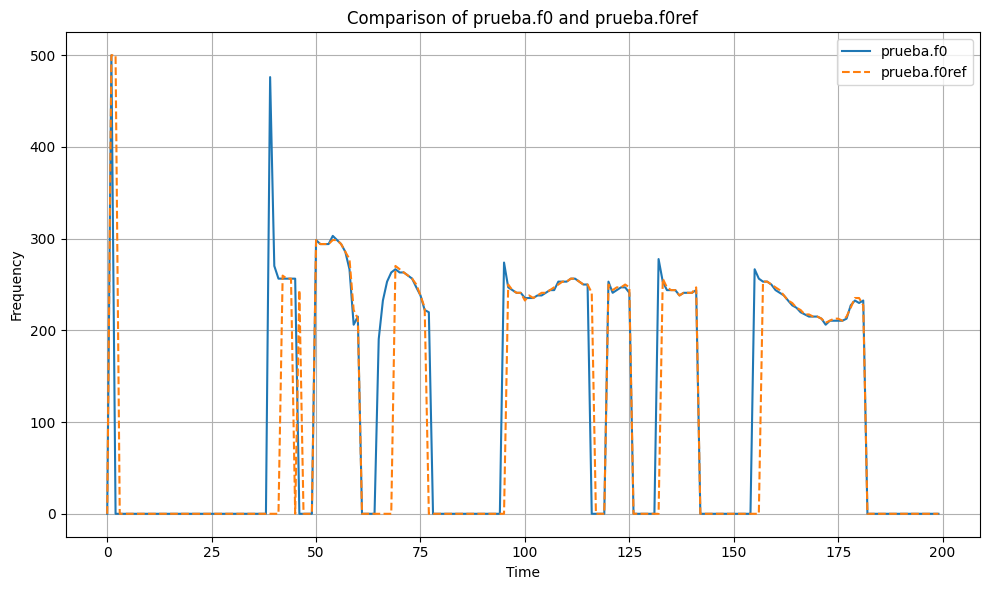

In [9]:
import matplotlib.pyplot as plt

with open('../../prueba.f0', 'r') as f:
    lines = f.readlines()
    prueba_f0_data = [float(line.strip()) for line in lines]

with open('../../prueba.f0ref', 'r') as f:
    lines = f.readlines()
    prueba_f0ref_data = [float(line.strip()) for line in lines]

plt.figure(figsize=(10, 6))
plt.plot(prueba_f0_data, label='prueba.f0')
plt.plot(prueba_f0ref_data, label='prueba.f0ref', linestyle='--')

plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Comparison of prueba.f0 and prueba.f0ref')
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()


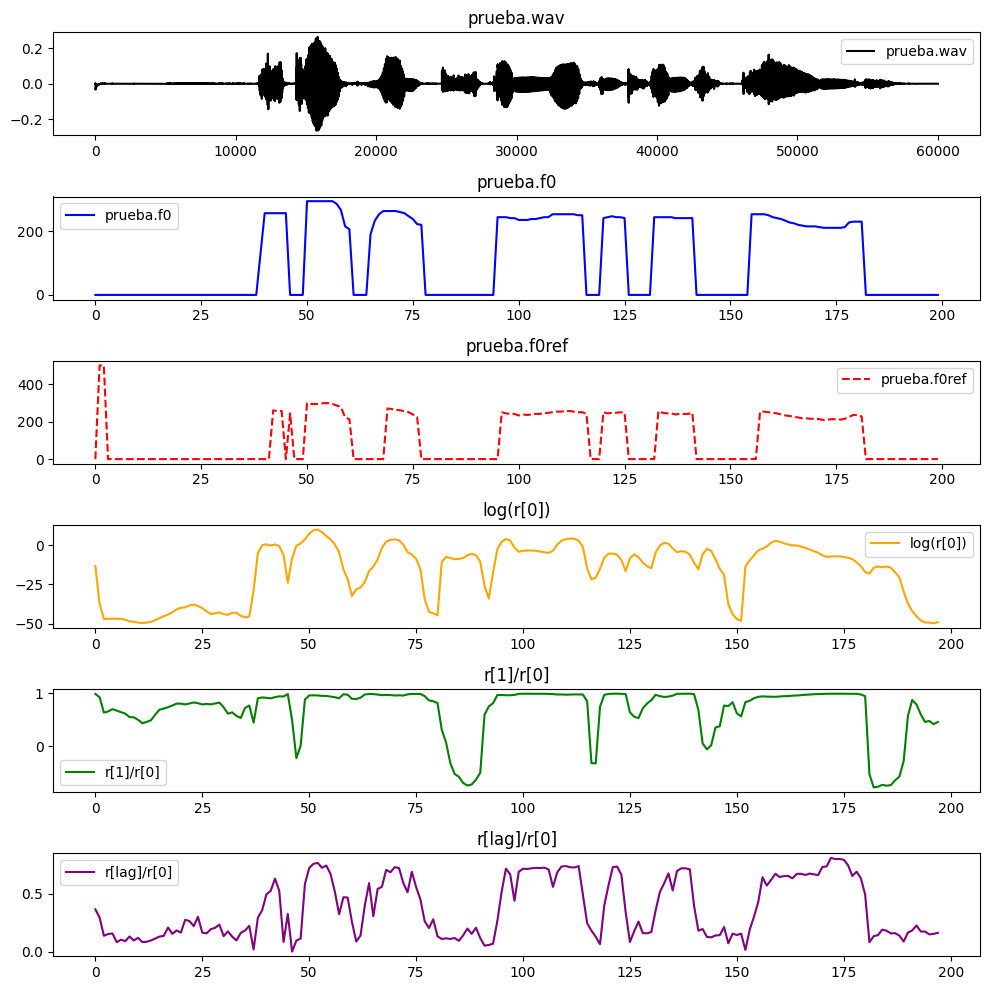

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
from scipy.signal import correlate
import soundfile as sf

with open('../../prueba.f0', 'r') as f:
    lines = f.readlines()
    prueba_f0_data = [float(line.strip()) for line in lines]

with open('../../prueba.f0ref', 'r') as f:
    lines = f.readlines()
    prueba_f0ref_data = [float(line.strip()) for line in lines]

prueba_wav, sr = sf.read('../../prueba.wav')

window_size_ms = 30
window_size = int(window_size_ms * sr / 1000)  # Convert to samples
hop_size_ms = 15
hop_size = int(hop_size_ms * sr / 1000)  # Convert to samples

r_0 = []
r_1 = []
r_lag = []

for i in range(0, len(prueba_wav) - window_size, hop_size):
    prueba = prueba_wav[i:window_size+i]
    r = np.correlate(prueba, prueba, mode='full')  # Autocorrelation
    r_ = r[len(r)//2:]
    r0 = r_[0]  # r[0] (power)
    r1 = r_[1]
    lag = np.argmax(r_[100:]) + 100  # Index of maximum (lag)
    r_max = r_[lag]
    r_0.append(r0)
    r_1.append(r1)
    r_lag.append(r_max)
    
r_1 = np.array(r_1)
r_0 = np.array(r_0)
r_lag = np.array(r_lag)
    
fig, axs = plt.subplots(6, 1, figsize=(10, 10))

axs[0].plot(prueba_wav, color='black', label='prueba.wav')
axs[0].set_title('prueba.wav')
axs[0].legend()

axs[1].plot(prueba_f0_data, color='blue', label='prueba.f0')
axs[1].set_title('prueba.f0')
axs[1].legend()

axs[2].plot(prueba_f0ref_data, color='red', linestyle='--', label='prueba.f0ref')
axs[2].set_title('prueba.f0ref')
axs[2].legend()

axs[3].plot(10*np.log10(r_0), color='orange', label='log(r[0])')
axs[3].set_title('log(r[0])')
axs[3].legend()

axs[4].plot(r_1/r_0, color='green', label='r[1]/r[0]')
axs[4].set_title('r[1]/r[0]')
axs[4].legend()

axs[5].plot(r_lag/r_0, color='purple', label='r[lag]/r[0]')
axs[5].set_title('r[lag]/r[0]')
axs[5].legend()

plt.tight_layout()

plt.show()